In [ ]:
import os
import glob

In [ ]:
path = '/content/drive/My Drive/Dataset'

In [ ]:
# Get Image names stored in "Images" folder
image_path_names=[]
person_names=set()
for file_name in glob.glob('/content/drive/My Drive/Data'+'/Training_Set/*_[1-9]*.png'):
  image_path_names.append(file_name)
  person_names.add(image_path_names[-1].split('/')[-1].split('_')[0])

In [ ]:
len(image_path_names)

100

In [ ]:
os.mkdir(path+'/Training Set/')
for person in person_names:
  os.mkdir(path+'/Training Set/'+person+'/')

In [ ]:
os.mkdir(path+'/Testing Set/')
for person in person_names:
  os.mkdir(path+'/Testing Set/'+person+'/')

In [ ]:
pip install mtcnn

     |████████████████████████████████| 2.3MB 5.6MB/s 


In [ ]:
pip install keras_applications

     |████████████████████████████████| 51kB 2.6MB/s 


In [ ]:
import sys
import itertools
import cv2
import numpy as np
from PIL import Image
from numpy import asarray
from numpy import expand_dims
from mtcnn.mtcnn import MTCNN
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.callbacks import EarlyStopping
from keras.models import Model, Sequential
from keras.layers import Dense, Lambda
from keras.layers import Flatten, BatchNormalization
from keras.layers import Dropout
from keras.optimizers import SGD
from keras_vggface.vggface import VGGFace
from keras_vggface.utils import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix


In [ ]:
def define_model():
    model = VGGFace(model='resnet50', include_top = False, input_shape=(224, 224, 3), pooling='avg')
    model.trainable = False
    for layer in model.layers:
      if "BatchNormalization" in layer.__class__.__name__:
        layer.trainable = True
    flat1 = Flatten()(model.layers[-1].output)
    class1 = Dense(1024, activation='relu')(flat1)
    drop = Dropout(0.2)(class1)
    output = Dense(10, activation='softmax')(drop)
	# define new model
    model = Model(inputs=model.inputs, outputs=output)
	# compile model
    opt = SGD(lr=0.001, momentum = 0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
model = define_model()
model.summary()

Model: "model_52"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_53 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_53[0][0]                   
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_2548 (Activation)    (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
___________________________________________________________________________________________

In [ ]:
def summarize_diagnostics(history):
	# plot loss
	plt.subplot(211)
	plt.title('Cross Entropy Loss')
	plt.plot(history.history['loss'], color='blue', label='train')
	plt.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	plt.subplot(212)
	plt.title('Classification Accuracy')
	plt.plot(history.history['accuracy'], color='blue', label='train')
	plt.plot(history.history['val_accuracy'], color='orange', label='test')
	plt.legend()
	#filename = sys.argv[0].split('/')[-1]
	#plt.savefig(filename + '_plot.png')
	plt.show()

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
def extract_face(filename, required_size=(224, 224)):
	# load image from file
    pixels = cv2.imread(filename)
	# create the detector, using default weights
    detector = MTCNN()
	# detect faces in the image
    results = detector.detect_faces(pixels)
	# extract the bounding box from the first face
    x1, y1, width, height = results[0]['box']
    x2, y2 = x1 + width, y1 + height
	# extract the face
    face = pixels[y1:y2, x1:x2]
	# resize pixels to the model size
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = asarray(image)
    pixels = face_array
    pixels = pixels.astype('float32')
    samples = expand_dims(pixels, axis=0)
    # prepare the face for the model, e.g. center pixels
    samples = preprocess_input(samples, version=2)
    return samples

In [ ]:
def run_test_harness():
	# define model
    model = define_model()
	# create data generator
    datagen = ImageDataGenerator(featurewise_center=True)
	# prepare iterator
    train_it = datagen.flow_from_directory(path+ '/Training Set', batch_size = 10, 
                                           target_size=(224, 224))
    test_it = datagen.flow_from_directory(path+'/Testing Set', batch_size = 1,
                                          target_size=(224, 224))
	# fit model
    #es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
    history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
                                  validation_data=test_it, validation_steps=len(test_it), epochs=10, verbose=1)
    # evaluate model on training set
    _, acc1 = model.evaluate_generator(train_it, steps=len(train_it), verbose=0)
    print('> %.3f' % (acc1 * 100.0))
	# evaluate model on testing set
    _, acc2 = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
    print('> %.3f' % (acc2 * 100.0))

	# learning curves
    summarize_diagnostics(history)

    target_names = ['Boris', 'Brazil', 'Frank', 'Italy', 'Japan', 'Joe', 'Justin', 'Macron', 'Ram', 'Xi']

    Y_pred_train = model.predict_generator(train_it)
    y_pred_train = np.argmax(Y_pred_train, axis=1)
    print('Confusion Matrix Train')
    cnf_matrix = confusion_matrix(train_it.labels, y_pred_train)
    print(plot_confusion_matrix(cnf_matrix, classes=target_names, normalize= False,  title='Confusion matrix Train'))

    print('\n')
    
    plt.figure()
    Y_pred_test = model.predict_generator(test_it)
    y_pred_test = np.argmax(Y_pred_test, axis=1)
    print('Confusion Matrix Test')
    cnf_matrix1 = confusion_matrix(test_it.labels, y_pred_test)
    print(plot_confusion_matrix(cnf_matrix1, classes=target_names, normalize= False,  title='Confusion matrix Test'))

    # Save model for later use
    tf.keras.models.save_model(model,'/content/drive/My Drive/ResNet50.h5')

Found 100 images belonging to 10 classes.
Found 20 images belonging to 10 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/10
10/10 [==============================] - 61s 6s/step - loss: 3.8108 - accuracy: 0.0916 - val_loss: 2.4185 - val_accuracy: 0.1000
Epoch 2/10
10/10 [==============================] - 56s 6s/step - loss: 2.3039 - accuracy: 0.2988 - val_loss: 2.4347 - val_accuracy: 0.1500
Epoch 3/10
10/10 [==============================] - 56s 6s/step - loss: 1.0679 - accuracy: 0.7059 - val_loss: 2.3366 - val_accuracy: 0.2000
Epoch 4/10
10/10 [==============================] - 56s 6s/step - loss: 0.5242 - accuracy: 0.8727 - val_loss: 2.3036 - val_accuracy: 0.2000
Epoch 5/10
10/10 [==============================] - 56s 6s/step - loss: 0.2248 - accuracy: 0.9558 - val_loss: 2.1897 - val_accuracy: 0.3000
Epoch 6/10
10/10 [==============================] - 55s 6s/step - loss: 0.1466 - accuracy: 0.9679 - val_loss: 2.0108 - val_accuracy: 0.3500
Epoch 7/10
10/10 [==============================] - 56s 6s/step - loss: 0.0841 - accuracy: 0.9892 - val_loss: 1.8698 - val_accuracy: 0.4000
Epoch 8/10
10/10 [==

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


> 78.000
> 50.000


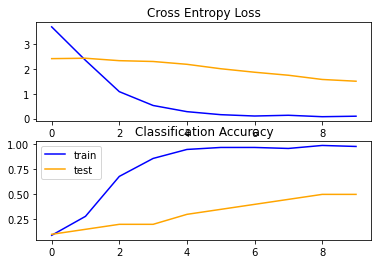

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Confusion Matrix Train
Confusion matrix, without normalization
[[2 2 1 1 0 0 0 3 0 1]
 [0 1 1 1 1 0 2 2 1 1]
 [1 1 1 0 2 0 0 2 1 2]
 [2 1 1 0 1 0 2 1 2 0]
 [2 1 2 0 0 2 0 3 0 0]
 [0 0 1 1 0 2 2 0 0 4]
 [2 0 0 1 1 1 0 2 0 3]
 [0 1 2 1 1 1 3 0 0 1]
 [0 4 0 2 0 1 0 2 1 0]
 [0 1 1 0 0 2 1 1 3 1]]
None


Confusion Matrix Test
Confusion matrix, without normalization
[[1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 1 0 0]
 [0 0 0 0 0 0 0 1 0 1]
 [0 0 0 0 0 0 0 2 0 0]
 [1 0 0 0 0 1 0 0 0 0]
 [0 1 0 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0 1 0]
 [1 0 0 0 0 0 1 0 0 0]
 [1 1 0 0 0 0 0 0 0 0]
 [0 0 0 1 1 0 0 0 0 0]]
None


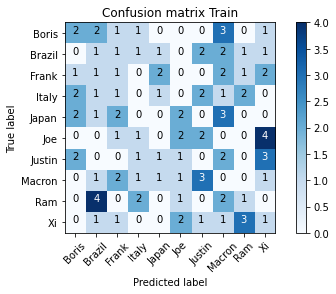

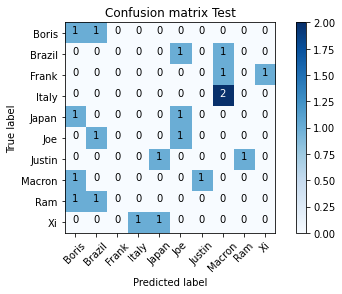

In [ ]:
run_test_harness()